In [1]:
# import packages
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import Quandl

# Predicting 12-Month Rates, using 3-Month, 6-Month, and Fed Funds Rate

## Data Wrangling

In [2]:
# read in Fed Funds Rate, 3-Month, 6-Month, 12-Month Treasury Bill data from Quandl
three_month = Quandl.get("FRED/DGS3MO")
six_month = Quandl.get("FRED/DGS6MO")
twelve_month = Quandl.get("FRED/DGS1")
fed_rate = Quandl.get("FRED/DFF")

In [3]:
# reset indices 
three_month.reset_index(level=0, inplace=True)
six_month.reset_index(level=0, inplace=True)
twelve_month.reset_index(level=0, inplace=True)
fed_rate.reset_index(level=0, inplace=True)

In [4]:
# limit 12-Month Treasuries and Fed Funds Rate to after 1982-01-04
twelve_month = twelve_month[(twelve_month['DATE'] >= '1982-01-04')]
twelve_month = twelve_month.reset_index(drop=True)

fed_rate = fed_rate[(fed_rate['DATE'] >= '1982-01-04')]
fed_rate = fed_rate.reset_index(drop=True)

In [5]:
# normalize data to heave mean = 0, std = 1
three_month['normal'] = (three_month['VALUE'] - three_month['VALUE'].mean(axis=0)) / three_month['VALUE'].std(axis=0, ddof=1)
six_month['normal'] = (six_month['VALUE'] - six_month['VALUE'].mean(axis=0)) / six_month['VALUE'].std(axis=0, ddof=1)
twelve_month['normal'] = (twelve_month['VALUE'] - twelve_month['VALUE'].mean(axis=0)) / twelve_month['VALUE'].std(axis=0, ddof=1)
fed_rate['normal'] = (fed_rate['VALUE'] - fed_rate['VALUE'].mean(axis=0)) / fed_rate['VALUE'].std(axis=0, ddof=1)

In [6]:
# merge into single DataFrame
data = three_month.merge(six_month, on = 'DATE')
data = data.merge(twelve_month, on = 'DATE')
data = data.merge(fed_rate, on = 'DATE')

In [7]:
# rename columns
data.columns = ['date', '3_rate', '3_norm', '6_rate', '6_norm', '12_rate', '12_norm', 'fed_rate', 'fed_norm']

## Plot

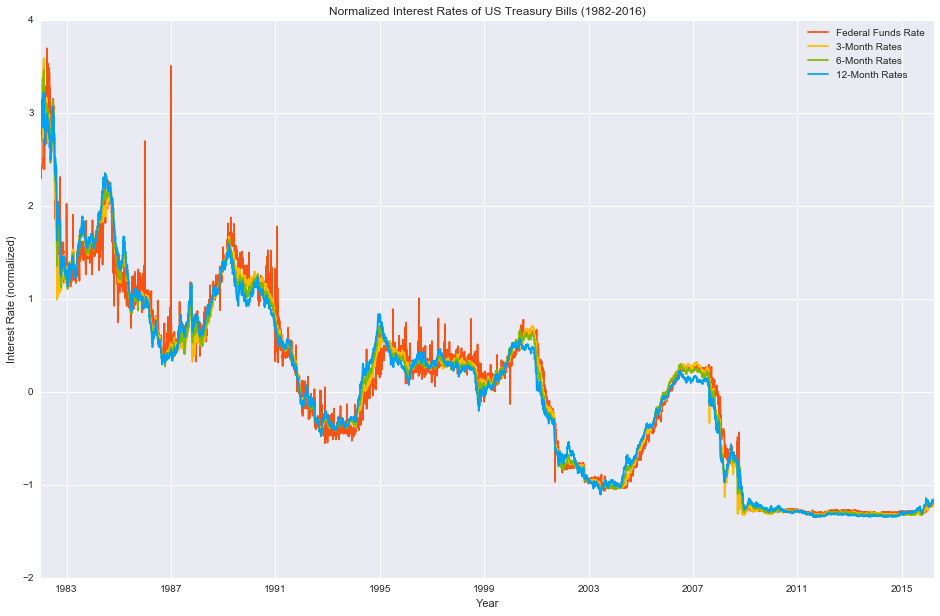

In [8]:
# plot to see what the normalized data look like
figure, ax = plt.subplots(figsize=(16,10))
ax.plot(data['date'], data['fed_norm'], label = 'Federal Funds Rate', color = '#F65314')
ax.plot(data['date'], data['3_norm'], label = '3-Month Rates', color = '#FFBB00')
ax.plot(data['date'], data['6_norm'], label = '6-Month Rates', color = '#7CBB00')
ax.plot(data['date'], data['12_norm'], label = '12-Month Rates', color = '#00A1F1')


ax.set_xlabel('Year')
ax.set_ylabel('Interest Rate (normalized)')
ax.set_title('Normalized Interest Rates of US Treasury Bills (1982-2016)')

ax.legend()

## Neural Network

In [9]:
# set random seed
np.random.seed(3232016)

# slice a third of dataset for training set
size = len(data)/3
train_rows = data.sample(size)

# assign training set and test set
train_data = data.ix[train_rows.index]
test_data = data.drop(train_rows.index)

print (len(train_data))
print (len(test_data))

2852
5704


In [10]:
# slice train dataset and reshape into 2D array
x3_train = (train_data['3_norm']).reshape((len(train_data),1))
x6_train = (train_data['6_norm']).reshape((len(train_data),1))
xfed_train = (train_data['fed_norm']).reshape((len(train_data),1))
x_train = np.concatenate((x3_train, x6_train, xfed_train), axis=1)

# slice test dataset and reshape into 2D array
x3_test = (test_data['3_norm']).reshape((len(test_data),1))
x6_test = (test_data['6_norm']).reshape((len(test_data),1))
xfed_test = (test_data['fed_norm']).reshape((len(test_data),1))
x_test = np.concatenate((x3_test, x6_test, xfed_test), axis=1)

In [11]:
from function_approximator import FunctionApproximator

# set random seed
np.random.seed(3232016)

# define the function approximator
fa = FunctionApproximator(n_in=3, n_out=1, n_hidden=5)

# use normalized sample of 12-Month rates as y for training
y = (train_data['12_norm']).reshape((len(train_data),1))

# train the model
fa.train(x_train, y, learning_rate=0.05, n_epochs=200000, report_frequency=20000)

epoch: 20000  cost: 0.001659
epoch: 40000  cost: 0.001634
epoch: 60000  cost: 0.001622
epoch: 80000  cost: 0.001614
epoch: 100000  cost: 0.001608
epoch: 120000  cost: 0.001603
epoch: 140000  cost: 0.001599
epoch: 160000  cost: 0.001596
epoch: 180000  cost: 0.001592
epoch: 200000  cost: 0.001589


In [12]:
# define y test vector
y_test = test_data['12_norm'].reshape((len(test_data), 1))

In [13]:
# print mean squared error of test set
y_bar = fa.get_y_pred(x_test)
print (((y_test - y_bar) ** 2).mean(axis=0))

[ 0.00156899]


This mean squared error is slightly lower than that of our model without the Fed Funds rate, which was:

[ 0.00170591]

In [14]:
# test model on remaining 3-Month, 6-Month, and Fed Funds rates to predict 12-Month rates
y_predict = fa.get_y_pred(x_test)

In [15]:
# create lists for plotting
test_data_x = test_data['date'].tolist()
data_x = data['date'].tolist()

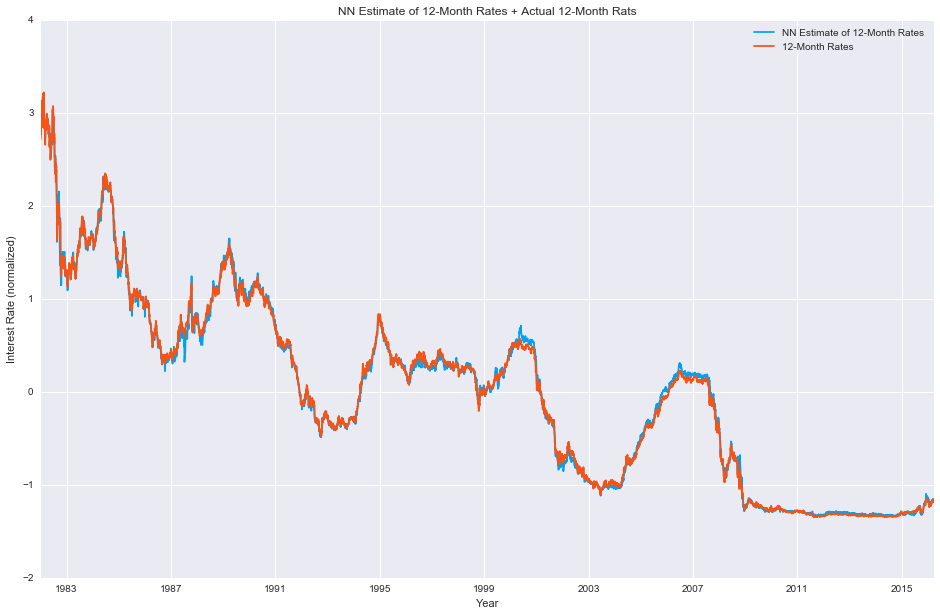

In [16]:
# plot to see what the prediction looks like vs the actual data
figure, ax = plt.subplots(figsize=(16,10))
ax.plot(test_data_x, y_predict, label = 'NN Estimate of 12-Month Rates', color = '#00A1F1')
ax.plot(data_x, data['12_norm'], label = '12-Month Rates', color = '#F65314')

ax.set_xlabel('Year')
ax.set_ylabel('Interest Rate (normalized)')
ax.set_title('NN Estimate of 12-Month Rates + Actual 12-Month Rats')

ax.legend()